In [9]:
%cd ..

import matplotlib.axes._axes as axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.gabor_analysis.gabor_fit import GaborFit
from src.spikeloader import SpikeLoader

sns.set()

In [2]:
f = SpikeLoader.from_hdf5('data/processed.hdf5')
g = GaborFit.from_hdf5('data/gabor.hdf5')
deg = 2.5

In [15]:
# Get data and center.
pos = f.pos[['x', 'y']].to_numpy().astype(np.float)
pos -= np.mean(pos, axis=0)

# Standardize z in both dims.
y = g.params_fit[:, GaborFit.KEY['pos_x']]
xs, ys = [LinearRegression().fit(pos[:, i, None], y).coef_ for i in range(2)]
pos /= np.array([xs, ys]).flatten()

# Get angle from multiple linear regression.
res = LinearRegression().fit(pos, y)
θ = np.pi / 2 - np.arctan(res.coef_[1] / res.coef_[0])

# Rotation matrix
c, s = np.cos(θ), np.sin(θ)
R = np.array(((c, -s), (s, c)))

# Rotate data.
pos = f.pos[['x', 'y']].to_numpy().astype(np.float)
pos = np.rint(pos @ R)
pos = pd.DataFrame(data=pos, columns=['x', 'y'])


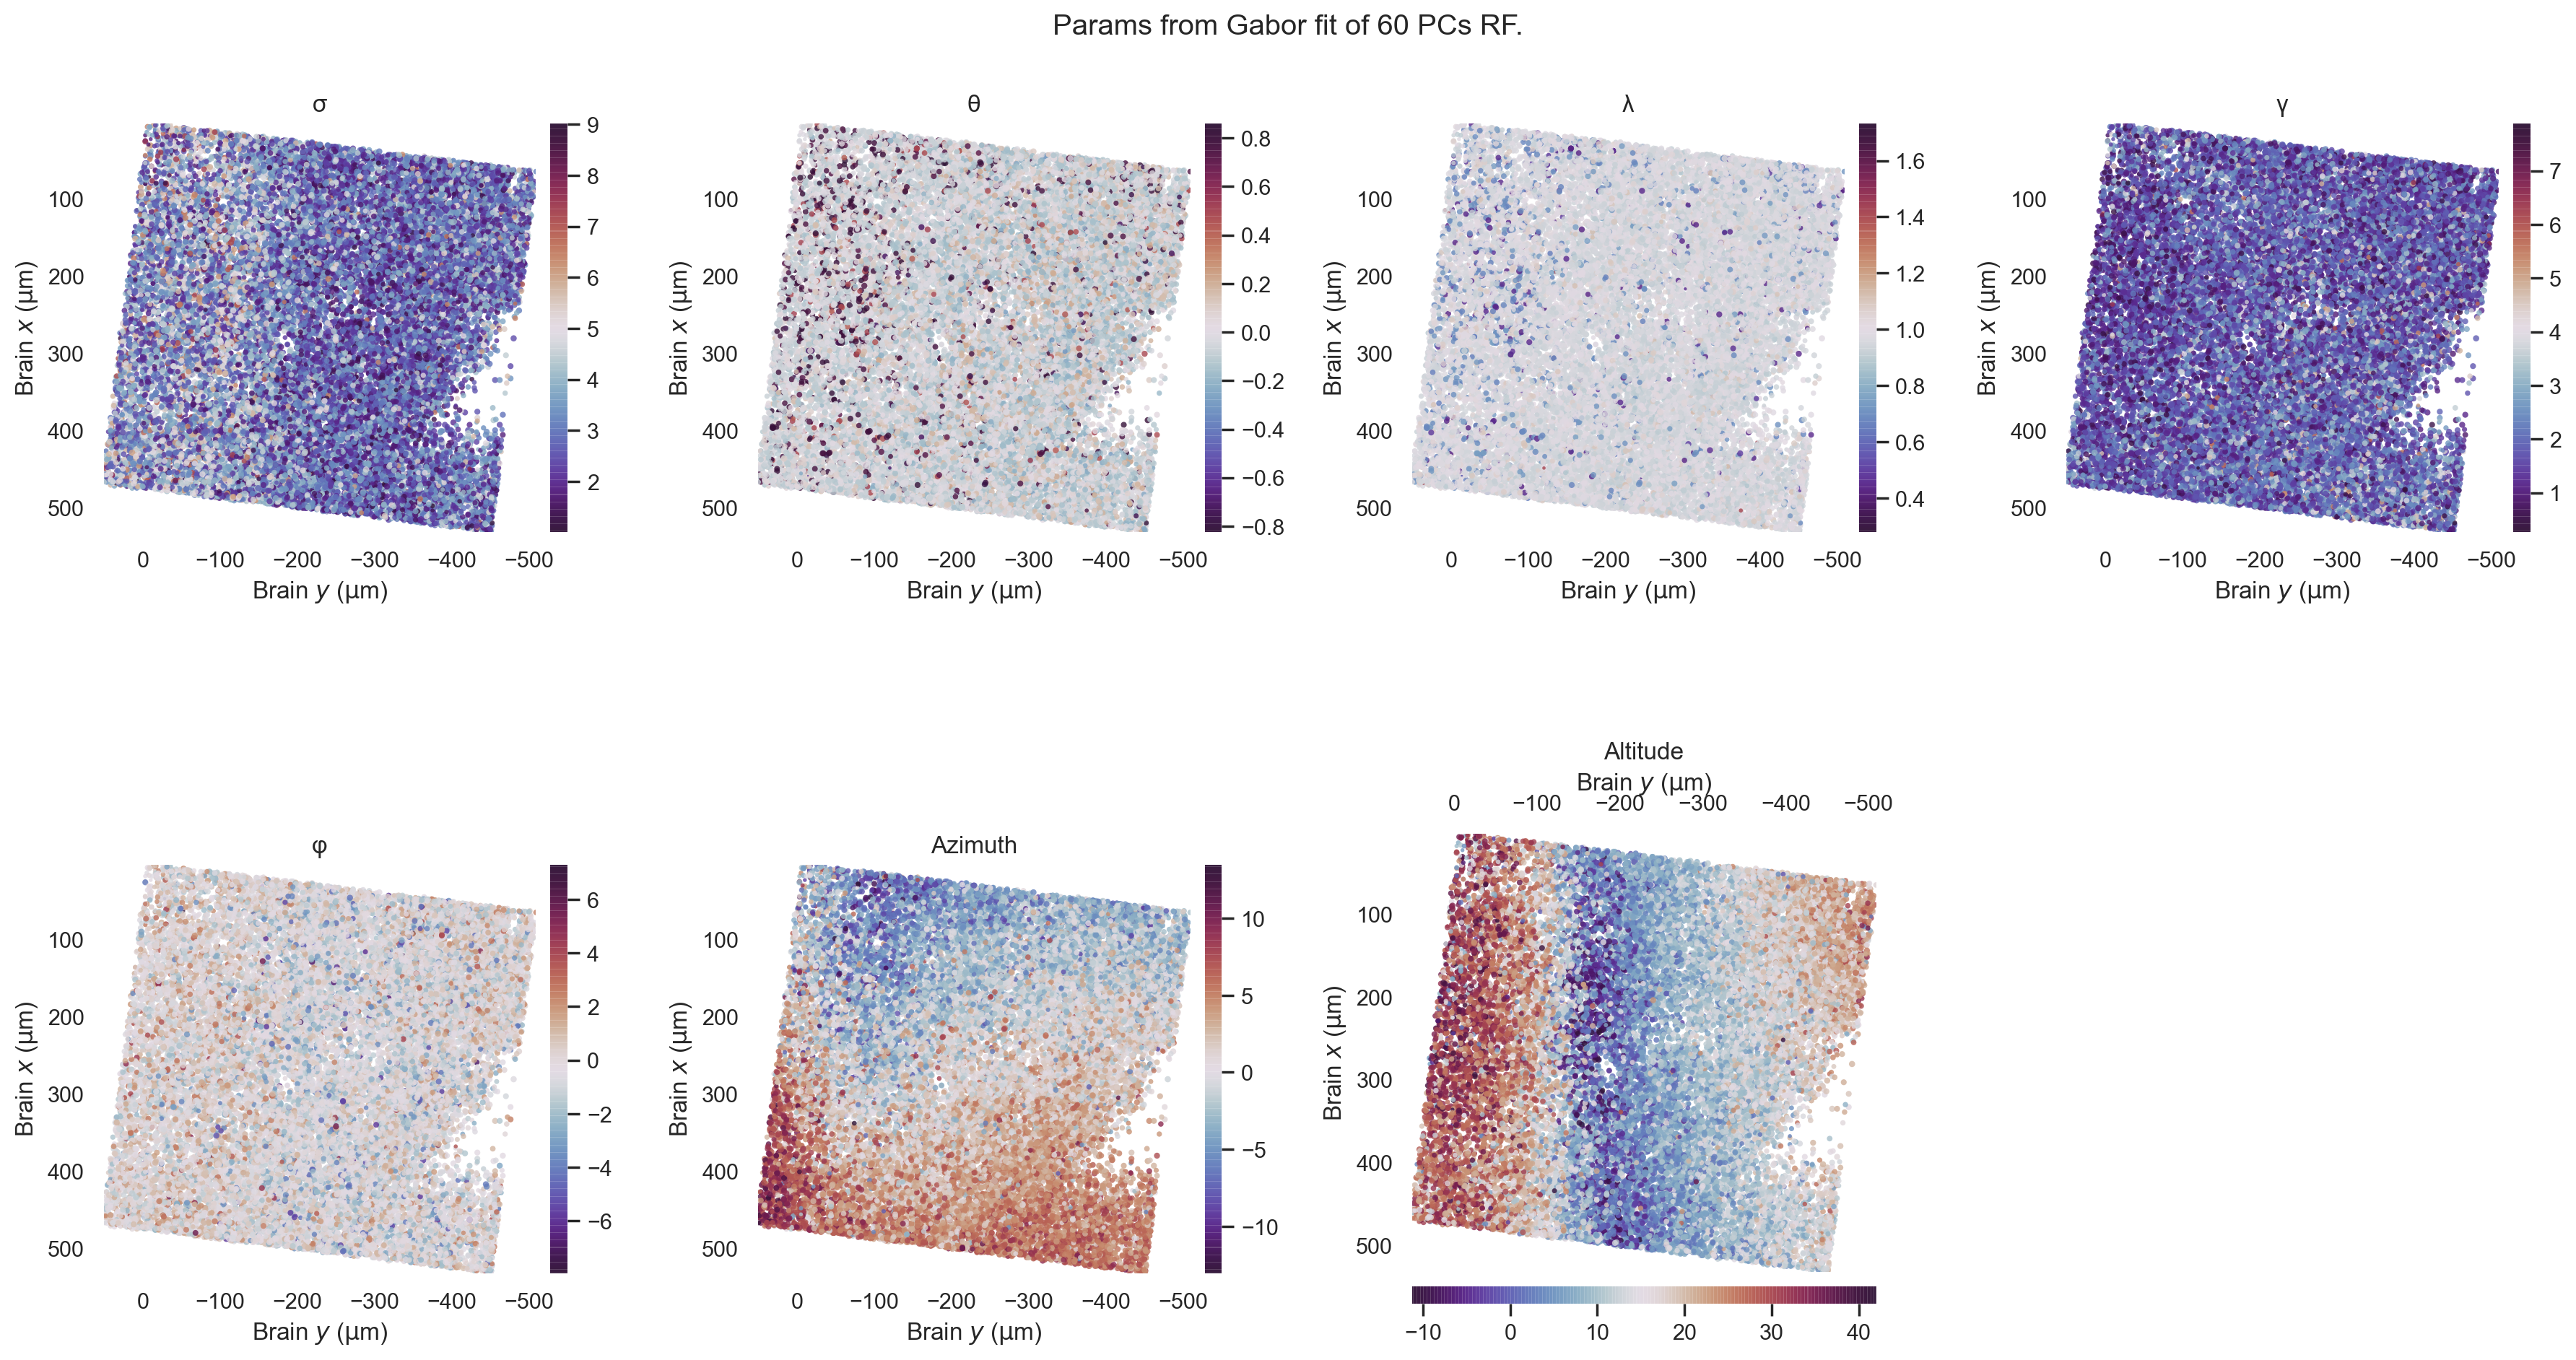

In [17]:
cmap = 'twilight_shifted'
def plot_scatter(ax, p, title):
    sns.set_style('whitegrid')
    scale = np.max(np.abs(p))
    u = ax.scatter(x:=-pos['y'], y:=pos['x'],
                   s=10 * g.corr, c=p, linewidth=0,
                   cmap=cmap, alpha=0.8)#, vmin=-scale, vmax=scale)
    ax.grid(0)
    ax.set_aspect('equal')
    ax.set_xlabel('Brain $y$ ($\mathrm{\mu}$m)')
    ax.set_ylabel('Brain $x$ ($\mathrm{\mu}$m)')
    ax.set_xlim([np.max(x), np.min(x)])
    ax.set_ylim([np.min(y), np.max(y)])
    ax.set_ylim(ax.get_ylim()[::-1])

    for spine in ax.spines.values():
        spine.set_visible(False)

    divider = make_axes_locatable(ax)
    
    if title == 'Azimuth':
        cax = divider.append_axes("bottom", size="4%", pad=0.1, )
        cbar = fig.colorbar(u, cax=cax, orientation='horizontal')
#         cbar.ax.set_xlabel(title, fontweight='bold', fontsize='large', labelpad=10)

        ax.xaxis.set_ticks_position('top')
        ax.tick_params(color='white')
        ax.xaxis.set_label_position('top')
        ax.xaxis.set_label_coords(0.5, 1.1)  # 1 is top, right
        
    else:
        cax = divider.append_axes("right", size="4%", pad=0.1, )
        cbar = fig.colorbar(u, cax=cax, )
#         cbar.ax.set_ylabel(title, rotation=270, fontweight='bold', fontsize='large', labelpad=12)

    cbar.outline.set_visible(False)


fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(18, 10), dpi=200)
axs = axs.flatten()
for name, i in GaborFit.KEY.items():
    ax = axs[i]
    if 'pos' not in name:
        plot_scatter(ax, g.params_fit[:, i], name)
        ax.set_title(name)



plot_scatter(axs[-3], deg * g.params_fit[:, -1], 'Altitude')
axs[-3].set_title('Azimuth')
plot_scatter(axs[-2], deg * -g.params_fit[:, -2], 'Azimuth')
axs[-2].set_title('Altitude')

fig.delaxes(axs[-1])
fig.suptitle('Params from Gabor fit of 60 PCs RF.')
plt.tight_layout()


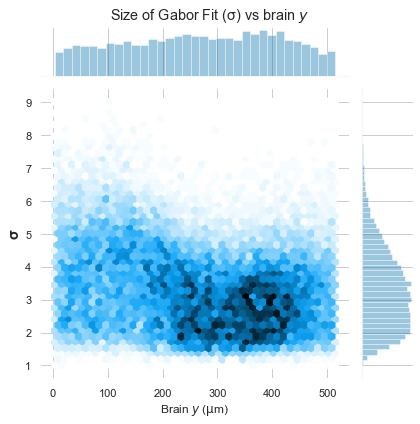

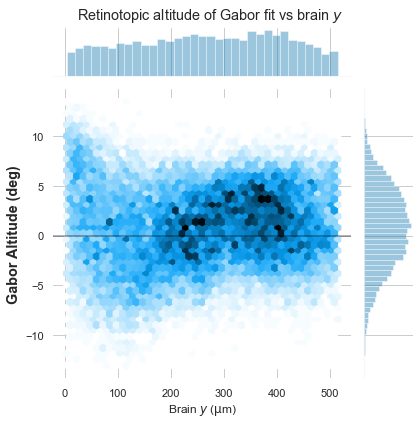

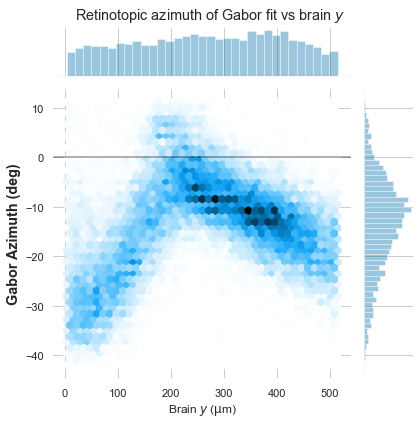

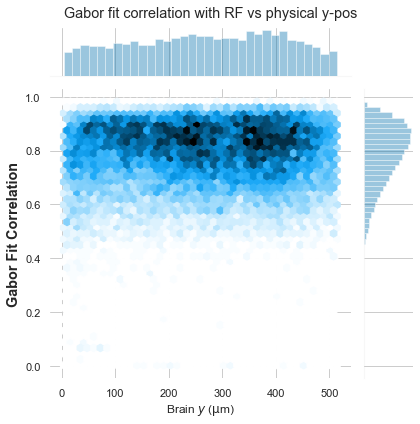

In [5]:
def make_hexplot(var, name, axis, title=None, save=None, line=False):
    with sns.color_palette('colorblind', desat=0.95):
        df = pd.DataFrame([f.pos[axis], var]).T
        df.columns = [f'Brain ${axis}$ ($\mathrm{{\mu}}$m)', name]
        g = sns.jointplot(data=df, x=df.columns[0], y=df.columns[1], kind='hex')
        g.fig.suptitle(title)

        for sp in g.ax_joint.spines.values():
            sp.set_visible(False)

        g.ax_joint.set_ylabel(name, fontweight='bold', fontsize='large')

        ax: axes.Axes
        for ax in [g.ax_marg_x, g.ax_marg_y]:
            for sp in ax.spines.values():
                sp.set_alpha(0.15)

        if line:
            ax = g.ax_joint
            ax.axhline(color='black', alpha=0.4)

        if save:
            plt.savefig(save)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


make_hexplot(g.params_fit[:, 0], 'σ', 'y', 'Size of Gabor Fit (σ) vs brain $y$')
make_hexplot(deg * g.params_fit[:, -1], 'Gabor Altitude (deg)', 'y', 'Retinotopic altitude of Gabor fit vs brain $y$',
             line=True)
make_hexplot(deg * g.params_fit[:, -2], 'Gabor Azimuth (deg)', 'y', 'Retinotopic azimuth of Gabor fit vs brain $y$',
             line=True)
make_hexplot(g.corr, 'Gabor Fit Correlation', 'y', 'Gabor fit correlation with RF vs physical y-pos')


## Altair Demo

In [6]:
list(GaborFit.KEY.keys())
names = ['sigma - size', 'theta - rot', 'lambda - freq', 'gamma - shape', 'phi - phase', 'gabor_x', 'gabor_y']

In [7]:
import altair as alt
df = pd.DataFrame(g.params_fit, columns=[name for name in names], dtype=np.float16)
df = df.join(f.pos)
df = df.join(pd.DataFrame(g.corr, columns=['corr'], dtype=np.float16))
df['z'] = df['z'].astype('category')
clip = 5
df['imgs'] = list(np.rint(np.clip(zscore(g.rf_pcaed, axis=(1,2)), -clip, clip) * (128 / clip) + 128).astype(np.uint8))  # list of 2D arrays


NameError: name 'zscore' is not defined

In [ ]:
brush = alt.selection_interval(resolve='global')
base = alt.Chart(df.sample(50))
from altair import datum
scatter = base.mark_point(stroke='gray', strokeWidth=1, strokeOpacity=0.4).encode(
    x='x', y='y',
    fill=alt.condition(brush, 'gabor_x', alt.ColorValue('gray'), scale=alt.Scale(scheme='redyellowblue'), sort='descending'),
    opacity=alt.condition(brush, alt.value(0.9), alt.value(0.05))
).add_selection(brush)


def make_int_hist(*args, **kwargs):
    hist = base.mark_bar()
    
    background = hist.transform_joinaggregate(
        total='count(*)'
    ).transform_calculate(
        pct='1 / datum.total'
    ).encode(
        x=alt.X(*args, **kwargs),
        y=alt.Y('sum(pct):Q'),
        color=alt.value('#ddd')
    ).add_selection(brush)

    
    highlight = hist.transform_filter(brush).transform_joinaggregate(
        total='count(*)'
    ).transform_calculate(
        pct='1 / datum.total'
    ).encode(
        x=alt.X(*args, **kwargs),
        y=alt.Y('sum(pct):Q'),
    )

    return background + highlight


imgs = base.transform_window(
    index='count()'           # number each of the images
).transform_filter(
    brush
).transform_sample(
    12
).transform_flatten(
    ['imgs']                 # extract rows from each image
).transform_window(
    row='count()',            # number the rows...
    groupby=['index']         # ...within each image
).transform_flatten(
    ['imgs']                 # extract the values from each row
).transform_window(
    column='count()',         # number the columns...
    groupby=['index', 'row']  # ...within each row & image
).mark_rect().encode(
    alt.X('column:O', axis=None),
    alt.Y('row:O', axis=None),
    alt.Color('imgs:Q',
        scale=alt.Scale(scheme='redblue'),
        legend=None
    ),
    alt.Facet('index:N', columns=4),
).properties(
    width=100,
    height=60
)


chart = (scatter | make_int_hist('z:O') | imgs).properties(title={'text': 'Physical Positions', 'subtitle': 'Color depicts Gabor x center'}) & \
    make_int_hist(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=40)).repeat(column=['sigma - size', 'lambda - freq', 'theta - rot']).properties(title='Gabor Fit Parameters') & \
    make_int_hist(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=40)).repeat(column=['phi - phase', 'gabor_x', 'gabor_y'])
    

chart.resolve_scale(color='independent').resolve_legend(color='independent')

In [ ]:
chart.save('chart.html')

In [ ]:
import altair as alt
from vega_datasets import data

cars = data.cars()

alt.Chart(df.sample(500)).mark_bar().encode(
    x=alt.X(alt.repeat('column'), type='quantitative', bin=True),
    y='count()',
    color=alt.Color(alt.repeat('column'), type='quantitative')
).properties(
    width=200,
    height=150
).repeat(column=['phi - phase', 'gabor_x', 'gabor_y'])